# Imports

In [1]:
import os
import cv2
import struct
import shutil
import numpy as np
import matplotlib.pyplot as plt

# Constant

In [2]:
POSITIVE_SAMPLE_VIDEO = '/kaggle/input/coffee-packets/sample_video.mov'
NEGATIVE_SAMPLE_VIDEO = '/kaggle/input/coffee-packets/negative_sample.mov'

# Utils

In [3]:
def extract_video_frames(video_path):
    # Initialize a list to store the frames
    frames = []

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
    else:
        # Loop through the video frames
        while True:
            # Read a frame from the video
            ret, frame = cap.read()

            # If the frame was read successfully, ret will be True
            if not ret:
                break

            # Convert the frame to a NumPy array and append it to the frames list
            frames.append(np.array(frame))

        # Release the video capture object
        cap.release()

    # Convert the list of frames to a NumPy array
    frames_array = np.array(frames)
    
    return frames_array


def write_vec_file(images, output_file):
    num_samples = len(images)
    img_height, img_width = images[0].shape[:2]
    
    with open(output_file, 'wb') as f:
        # Write header
        f.write(struct.pack('i', num_samples))
        f.write(struct.pack('i', img_width))
        f.write(struct.pack('i', img_height))
        f.write(struct.pack('i', 1))  # channels, assumed to be 1
        
        for img in images:
            # Flatten the image
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            f.write(struct.pack('i', 0))  # dummy value for the header of each image
            f.write(gray_img.tobytes())
            

def train_haar_classifier():
    os.makedirs('data', exist_ok=True)
    os.makedirs('vec', exist_ok=True)

    # Create positive samples
    os.system('opencv_createsamples -info positive_samples.txt -vec positive_samples.vec -num 1000 -w 120 -h 260')

    # Train the classifier
    os.system('opencv_traincascade -data haar_cascade -vec positive_samples.vec -bg negative_samples.txt -numPos 800 -numNeg 400 -numStages 10 -w 120 -h 260')



def plt_img(img_data, cmap='viridis'):
    '''
    cmap:
      * 'bgr' (BRG)
      * 'gray' (Grayscale)
      * 'binary' (Binary)
    '''
    if cmap == 'bgr':
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        cmap = None

    plt.imshow(img_data, cmap=cmap)
    plt.axis('on')
    plt.show()
    
    
# def resize_images(img, width=120, height=260):
#     resized_img = cv2.resize(img, (width, height))
#     return resized_img

def resize_images(img, target_width=24, target_height=24):
    # Get original dimensions
    original_height, original_width = img.shape[:2]
    
    # Calculate aspect ratio
    aspect_ratio = original_width / original_height
    
    # Determine new dimensions
    if aspect_ratio > 1:
        # Image is wider than tall
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        # Image is taller than wide or square
        new_height = target_height
        new_width = int(target_height * aspect_ratio)
    
    # Resize the image while maintaining aspect ratio
    resized_img = cv2.resize(img, (new_width, new_height))
    
    # Create a new image with the target dimensions and a black background
    final_img = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    # Calculate the position to paste the resized image onto the final image
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2
    
    # Paste the resized image onto the final image
    final_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_img
    
    return final_img

# Step1: Extract Video Frames

In [4]:
positive_sample_frames = extract_video_frames(POSITIVE_SAMPLE_VIDEO)
negative_sample_frames = extract_video_frames(NEGATIVE_SAMPLE_VIDEO)

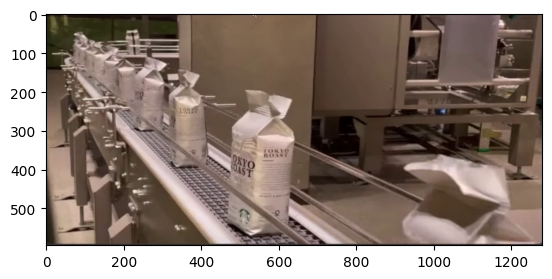

In [5]:
plt_img(positive_sample_frames[26], cmap='bgr')

# Step2: Extract ROI (Region of intereset i.e Coffee Packs)

In [6]:
coffee_packs = []

for frame in positive_sample_frames:
    # Define first ROI (Region of interest)
    x_start, y_start = 460, 190
    x_end, y_end = 640, 600
    roi = frame[y_start:y_end, x_start:x_end]
    coffee_packs.append(resize_images(roi))
    
    # Define second ROI (Region of interest)
    x_start, y_start = 300, 130 
    x_end, y_end = 420, 400
    roi = frame[y_start:y_end, x_start:x_end]
    coffee_packs.append(resize_images(roi))

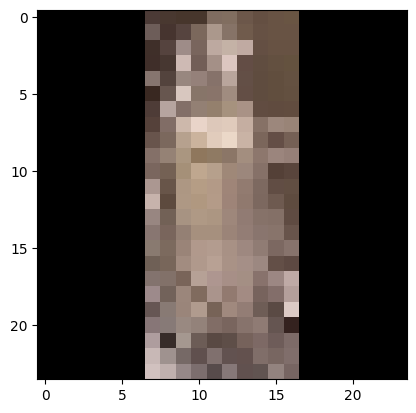

(24, 24, 3)


In [7]:
plt_img(coffee_packs[3], cmap='bgr')
print(coffee_packs[3].shape)

In [8]:
negative_samples = []

for frame in negative_sample_frames:
    # Define first ROI (Region of interest)
    x_start, y_start = 560, 190
    x_end, y_end = 740, 600
    roi = frame[y_start:y_end, x_start:x_end]
    negative_samples.append(resize_images(roi))

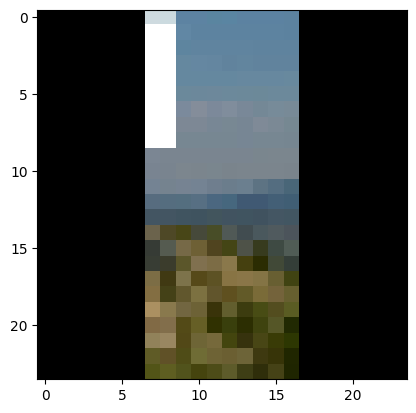

(24, 24, 3)


In [9]:
plt_img(negative_samples[100], cmap='bgr')
print(negative_samples[100].shape)

# Step3: Create Positive & Negative Samples

In [10]:
# Directory to save the images
output_dir = 'positive_images'
os.makedirs(output_dir, exist_ok=True)

# Save the images and create the positive samples file
with open('positive_samples.txt', 'w') as f:
    for i, img in enumerate(coffee_packs):
        img_path = os.path.join(output_dir, f'coffee_pack_{i}.jpg')
        cv2.imwrite(img_path, img)
        # Assuming the coffee pack occupies the entire image
        f.write(f'{img_path} 1 0 0 24 24\n')
        
# Write .vec file
write_vec_file(coffee_packs, 'positive_samples.vec')

In [11]:
# Directory to save the images
output_dir = 'negative_images'
os.makedirs(output_dir, exist_ok=True)

# Save the images and create the positive samples file
with open('negative_samples.txt', 'w') as f:
    for i, img in enumerate(negative_samples):
        img_path = os.path.join(output_dir, f'negative_sample{i}.jpg')
        cv2.imwrite(img_path, img)
        # Assuming the coffee pack occupies the entire image
        f.write(f'{img_path} 1 0 0 24 24\n')
        
# Write .vec file
write_vec_file(negative_samples, 'negative_samples.vec')

# Step4: Extract Haar Essentials

In [ ]:
# Define paths

data_dir = "/kaggle/working/"  # Adjust this path based on where your data is located
vec_file = os.path.join(data_dir, "positive_samples.vec")
bg_file = os.path.join(data_dir, "negative_samples.txt")
output_dir = os.path.join(data_dir, "classifier")

# Parameters for training
num_pos = 632
num_neg = 991
num_stages = 10
min_hit_rate = 0.995
max_false_alarm_rate = 0.5
width = 120
height = 260

# Create the classifier directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Construct the command for training the cascade
command = f"opencv_traincascade -data {output_dir} -vec {vec_file} -bg {bg_file} -numPos {num_pos} -numNeg {num_neg} -numStages {num_stages} -minHitRate {min_hit_rate} -maxFalseAlarmRate {max_false_alarm_rate} -w {width} -h {height}"

# Execute the command
os.system(command)

In [12]:
dir_to_zip = '/kaggle/working/positive_images'
output_zip_path = '/kaggle/working/positive_images.zip'
shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', dir_to_zip)

'/kaggle/working/positive_images.zip'

In [13]:
dir_to_zip = '/kaggle/working/negative_images'
output_zip_path = '/kaggle/working/negative_images.zip'
shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', dir_to_zip)

'/kaggle/working/negative_images.zip'